## 1. Packages

In [ ]:
import torch
from torch import nn
import numpy as np
import random
import mlxtend
# torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from timeit import default_timer as timer


import matplotlib.pyplot as plt

- **torchvision.datasets:** Get datasets and sata loading functions for computer vision.
- **tocrhvision.models:** Get pretrained computer vision models that you can levreage for ypur own problems.
- **torchvision.transforms:** Functions for manipulating your images to be suitable for your ML model.
- **torch.utils.data.Dataset:** Base dataset class for pytorch.
- **torch.utils.data.DataLoader:** Creates a python iterable over a dataset.

## 2. Getting Dataset

In [ ]:
# train data
train_data = datasets.FashionMNIST(
    root='data',
    download=True,
    train=True,
    transform=ToTensor(),
    target_transform=None
)

# test data
test_data = datasets.FashionMNIST(
    root='data',
    download=True,
    train=False,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:00<00:00, 116MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.89MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 57.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 4.01MB/s]


In [ ]:
# see the first training example:
type(train_data[0])

tuple

In [ ]:
# different classes in the data:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
# image dimensions
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

## 3. Visualizing random samples of data

Image shape : torch.Size([1, 28, 28])


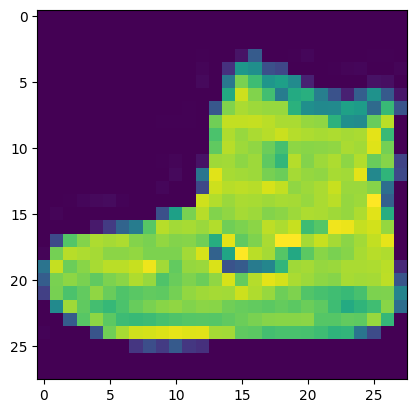

In [ ]:
# show the first image in the data:
image, label = train_data[0]
print(f'Image shape : {image.shape}')
plt.imshow(image.squeeze());

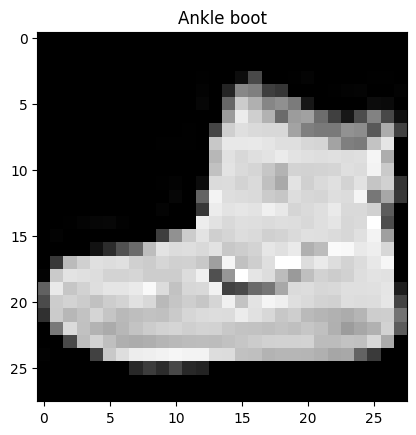

In [ ]:
# plot the image in gray scale:
plt.imshow(image.squeeze(), cmap='gray');
plt.title(class_names[label]);

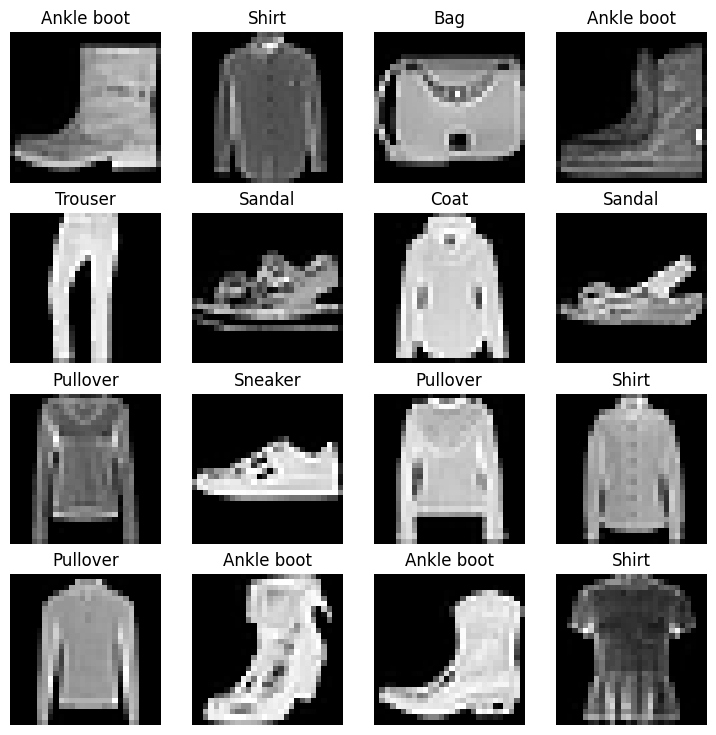

In [ ]:
# show some random photos:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9));
rows, cols = 4,4
for i in range(1, rows*cols +1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## 4. DataLoader Overview

In [ ]:
# Set up a batch_size:
BATCH_SIZE = 32
### create a train_dataloader:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
# create a test dataloader:
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

In [ ]:
# lenth of train_dataloader:
len(train_dataloader)

1875

In [ ]:
# check what inside a train dataloader:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

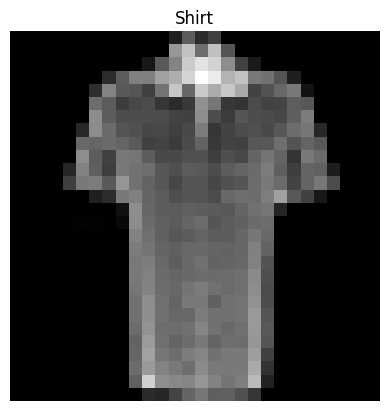

In [ ]:
# show a sample from data:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

## 5. Creating a baseline model

In [ ]:
# create a flatten layer:
flatten_model = nn.Flatten()

In [ ]:
# Get a single sample:
x = train_features_batch[0]
# flatten the sample:
output = flatten_model(x)

print(f"Shape before flatten : {x.shape}")
print(f"Shape after flatten : {output.shape}")

Shape before flatten : torch.Size([1, 28, 28])
Shape after flatten : torch.Size([1, 784])


In [ ]:
# create a baseline model:
class FashionMNISTV0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
# create an instance of a model:
torch.manual_seed(42)
model_0 = FashionMNISTV0(input_shape=784,
                         hidden_units=10,
                         output_shape=10)

In [ ]:
# predicy dummy sample:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 5.2 Creating a loss function and optimizer

In [ ]:
# accuracy function:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
# download helper function file:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
# Setup a loss function and optimizer:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### 5.3 Creating a function to time our expirements


In [ ]:
# create a function:
def print_train_time(start, end, device="cpu"):
  total_time = end - start
  print(f"Training time on {device} : {total_time:.3f} seconds")
  return total_time

In [ ]:
# test the timer function:
start_time = timer()
# some code
end_time = timer()
print_train_time(start_time, end_time)

Training time on cpu : 0.000 seconds


4.692299999931038e-05

### 5.4 Writing training and testing loops for our batched data

In [ ]:
# import tqdm for progress bar:
from tqdm.auto import tqdm

# set the torch seed and the starter time:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# set the number pf epochs:
epochs = 3

# creating train and test loops:
for epoch in tqdm(range(epochs)):

  print(f"Epoch : {epoch}\n---------")

  # Training:
  train_loss = 0
  ## Add a loop to loop through the training batches:
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    ## 1. fotward pass:
    y_pred = model_0(X)

    ## 2. calculate the loss:
    loss = loss_fn(y_pred, y)
    train_loss +=loss

    ## 3. optimizer zero grad:
    optimizer.zero_grad()

    ## 4. backward:
    loss.backward()

    ## 5. optimizer setup:
    optimizer.step()

    # print what's happen:
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)/len(train_dataloader.dataset)} samples")

  # the average total loss after batches training
  train_loss /= len(train_dataloader)

  # Testing loops
  test_acc, test_loss = 0, 0
  model_0.eval()

  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      ## 1. forward pass
      test_pred = model_0(X_test)
      ## 2. calculate the loss
      test_loss += loss_fn(test_pred, y_test)
      ## 3. calculate the accuracy:
      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

    # caclucalte the average loss:
    test_loss /= len(test_dataloader)

    # calculate the accuracy:
    test_acc /= len(test_dataloader)
  print(f"\nTrain loss : {train_loss:.4f} | Test loss : {test_loss:.4f} | Accuracy : {test_acc}")

# calculate the training time:
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu,
                                            train_time_end_on_cpu,
                                            next(model_0.parameters()).device)





  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
---------
Looked at 0.0 samples
Looked at 0.21333333333333335 samples
Looked at 0.4266666666666667 samples
Looked at 0.64 samples
Looked at 0.8533333333333334 samples

Train loss : 0.5904 | Test loss : 0.5102 | Accuracy : 82.03873801916933
Epoch : 1
---------
Looked at 0.0 samples
Looked at 0.21333333333333335 samples
Looked at 0.4266666666666667 samples
Looked at 0.64 samples
Looked at 0.8533333333333334 samples

Train loss : 0.4743 | Test loss : 0.5268 | Accuracy : 81.67931309904154
Epoch : 2
---------
Looked at 0.0 samples
Looked at 0.21333333333333335 samples
Looked at 0.4266666666666667 samples
Looked at 0.64 samples
Looked at 0.8533333333333334 samples

Train loss : 0.4537 | Test loss : 0.5126 | Accuracy : 82.99720447284345
Training time on cpu : 32.095 seconds


### 5.5 Writing an evaluation function

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc =0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim=1))

    # scale the loss and acc to find the everage loss/acc per batch:
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}




In [ ]:
# calculate the eval function for model_0:
model_0_results = eval_model(model_0,
                             test_dataloader,
                             loss_fn,
                             accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV0',
 'model_loss': 0.512529730796814,
 'model_acc': 83.00718849840256}

## 6. Setup Device-agnostic code

In [ ]:
# setup device agnostic code:
device = "gpu" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 7. Model 1 creating with non-linear functions

In [ ]:
# create a model  with non-linear and linear layers:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape,
               hidden_units,
               output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
# instantiate model_1:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(784, 10, 10).to(device)

### 7.1 Set up a loss function and an optimizer:


In [ ]:
# loss function:
loss = nn.CrossEntropyLoss()
# optimizer:
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


### 7.2 Turning our training loop into function

In [ ]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  train_loss, train_acc = 0, 0
  # set up in the train mode:
  model.train()
  for bacth, (X,y) in enumerate(data_loader):
    # transform the data into device
    X, y = X.to(device), y.to(device)
    # forward pass
    y_pred = model(X)
    # calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
    # optimizer zero grad
    optimizer.zero_grad()
    # backward
    loss.backward()
    # update the gradients
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss : {train_loss:.4f} | Train acc : {train_acc:.4f}")


### 7.3 Turning our testing loop into function

In [ ]:
def test_step(model, data_loader, loss_fn, accuracy_fn, device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X, y in data_loader:
      # send data to device
      X, y = X.to(device), y.to(device)
      # forward:
      test_pred = model(X)
      # calculate loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
    # adjust metrics:
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss : {test_loss:.4f} | Train loss {test_acc:.4f}")


In [ ]:
test_step(model_1, test_dataloader, loss_fn, accuracy_fn, device)

Test loss : 2.3021 | Train loss 10.7528


### 7.4 Training and testing loops model1 with our training/testing functions

In [ ]:
torch.manual_seed(42)

train_start_time = timer()
# set up epochs:
epochs = 3
# training and eval loops
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n--------")
  train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model_1, test_dataloader, loss_fn, accuracy_fn, device)

train_end_time = timer()
print_train_time(train_start_time, train_end_time, device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
--------
Train loss : 1.0920 | Train acc : 61.3433
Test loss : 0.9569 | Train loss 64.9760
Epoch : 1
--------
Train loss : 0.7378 | Train acc : 73.6933
Test loss : 0.7239 | Train loss 74.2113
Epoch : 2
--------
Train loss : 0.6678 | Train acc : 76.0767
Test loss : 0.6875 | Train loss 75.6390
Training time on cpu : 35.145 seconds


35.144958184000004

In [ ]:
# evaluate model_0:
model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.687465250492096,
 'model_acc': 75.64896166134186}

## 8. CNN model

In [ ]:
# create a CNN:
class FashionMNISTModeV2(nn.Module):

  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # create a conv layer:
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        # relu
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        # max pool
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=490,
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x




In [ ]:
# instantiate our cnn:
torch.manual_seed(42)
model_2 = FashionMNISTModeV2(input_shape=1,
                             hidden_units=10,
                             output_shape=10).to(device)

In [ ]:
# create a random tensor of the same shape:
rand_image_tensor = torch.randn(size=(1,28,28))
# pass through the model:
model_2(rand_image_tensor.unsqueeze(dim=1))

tensor([[ 0.0403, -0.0893,  0.0712, -0.0433,  0.0031,  0.0350,  0.0212,  0.0140,
         -0.0008, -0.0077]], grad_fn=<AddmmBackward0>)

### 8.1 Stepping through nn.Conv2d()

In [ ]:
torch.manual_seed(42)
# create a batch of images:
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Images shape : {images.shape}")
print(f"Single Image shape : {test_image.shape}")


Images shape : torch.Size([32, 3, 64, 64])
Single Image shape : torch.Size([3, 64, 64])


In [ ]:
# create a single conv2d layer:
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

In [ ]:
# conv2d output:
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### 8.2 stepping through nn.MAXPOOL2D

In [ ]:
print(f"The original test image shaoe {test_image.shape}")

The original test image shaoe torch.Size([3, 64, 64])


In [ ]:
# create a maxpool2d layer:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

In [ ]:
# convoluve the image:
conv_output = conv_layer(test_image)
print(f"Test image shape after conv {conv_output.shape}")

Test image shape after conv torch.Size([10, 62, 62])


In [ ]:
# pass the image through max pool:
pooling_output = max_pool_layer(conv_output)
print(f"Test image shape after pooling {pooling_output.shape}")

Test image shape after pooling torch.Size([10, 31, 31])


### 8.3 Loss function and optimizer

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer:
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### 8.4 Training and testing CNN model

In [ ]:
torch.manual_seed(42)

start_time = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n------")
  train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model_2, test_dataloader, loss_fn, accuracy_fn, device)

end_time = timer()
total_train_time = print_train_time(start_time, end_time, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
------
Train loss : 0.5560 | Train acc : 79.9783
Test loss : 0.3831 | Train loss 86.0124
Epoch : 1
------
Train loss : 0.3489 | Train acc : 87.5033
Test loss : 0.3728 | Train loss 86.7412
Epoch : 2
------
Train loss : 0.3093 | Train acc : 88.9200
Test loss : 0.3194 | Train loss 88.4185
Training time on cpu : 178.214 seconds


In [ ]:
# evaluate the model:
model_2_results = eval_model(model_2, test_dataloader, loss_fn, accuracy_fn)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModeV2',
 'model_loss': 0.3188073933124542,
 'model_acc': 88.43849840255591}

## 9. Making predictions on random test samples with the best trained model

In [ ]:
# make predictions:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # prepare the sample:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # forawrd pass:
      pred_logit = model(sample)

      # Get the predictions probailities:
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # get the pred prob off the gpu:
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)




In [ ]:
random.seed(42)
test_samples = []
test_labels = []
# randomly sampling 9 images:
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)



In [ ]:
# make predictions:
pred_probs = make_predictions(model_2, test_samples)

In [ ]:
# convert the predictions probs into labels:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1])

### 9.1 Plotting model predictions

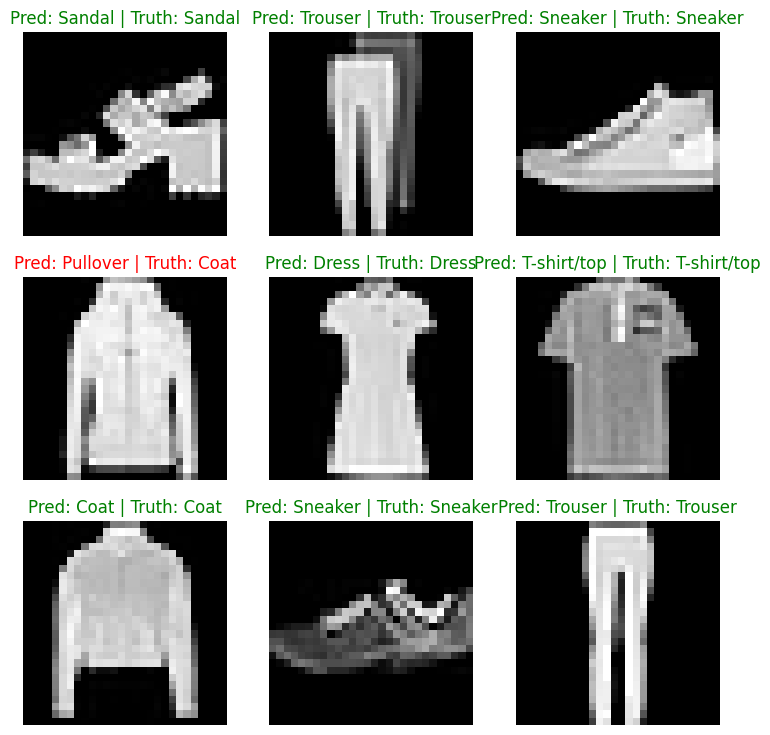

In [ ]:
# plot pedictions:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")
  # predicted label:
  pred_label = class_names[pred_classes[i]]
  # true label:
  true_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {true_label}"

  if pred_label == true_label:
    plt.title(title_text, c="g")
  else:
    plt.title(title_text, c="r")
  plt.axis(False);



### 9.2 Plot confusion matrix

In [ ]:
# make predictions:
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = model_2(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())




  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
len(y_preds)

313

In [ ]:
# concat the y_preds tensor:
y_preds_tensor = torch.cat(y_preds)
y_preds_tensor.shape

torch.Size([10000])

In [ ]:
# @title
# install torchmetrics:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 30.5 MB/s eta 0:00:00


In [ ]:
# import the confusion matrix:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
y_preds_tensor.shape

torch.Size([10000])

In [ ]:
# setup confusion instance:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds = y_preds_tensor,
                         target = test_data.targets)

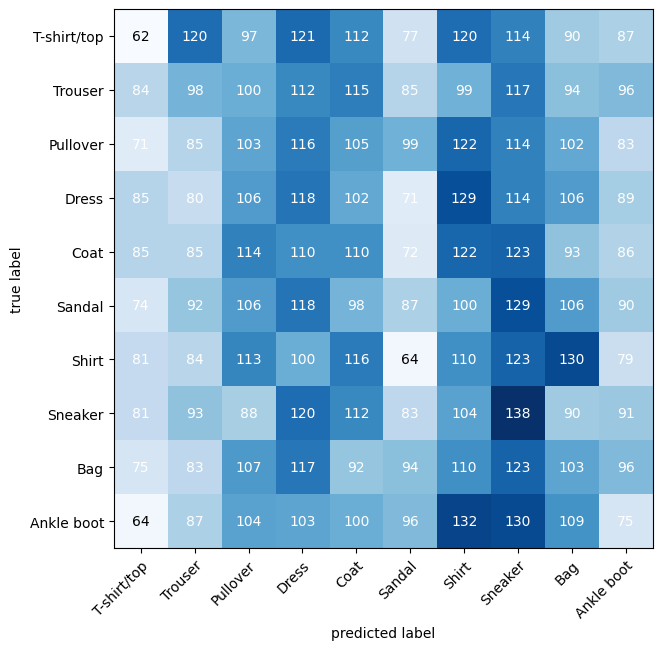

In [ ]:
# plot the confusion matrix:
fig, ax= plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10,7)
)

## 10. Save/Load our model

In [ ]:
from pathlib import Path

# create a model directory path:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save:
MODEL_NAME = "model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model:
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
# create new instance to load the model:
torch.manual_seed(42)
loaded_model_2 = FashionMNISTModeV2(input_shape=1,
                                    hidden_units=10,
                                    output_shape=len(class_names))

In [ ]:
# load the model:
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2.to(device)

FashionMNISTModeV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Evaluate the model:
torch.manual_seed(42)
loaded_model_2_results = eval_model(loaded_model_2, test_dataloader, loss_fn, accuracy_fn)
loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModeV2',
 'model_loss': 0.31910642981529236,
 'model_acc': 88.4185303514377}

In [ ]:
torch.manual_seed(42)
model_2_results = eval_model(model_2, test_dataloader, loss_fn, accuracy_fn)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModeV2',
 'model_loss': 0.31910642981529236,
 'model_acc': 88.4185303514377}

In [ ]:
# check if the models results are close:
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results['model_loss']))

tensor(True)